In [1]:
__depends__ = [
    "../../data/si_richardson16tcr/hist_rcp85",
    "../../data/cowtan_way/had4_krig_annual_v2_0_0.txt",
]
__dest__ = ["../../data/priestley-centre/observations/tas_obs.txt"]

In [2]:
data_path_richardson = __depends__[0]
data_path_cowtan_way = __depends__[1]
output_path = __dest__[0]

In [3]:
%load_ext nb_black

<IPython.core.display.Javascript object>

# TAS (GSAT) Observations

In this notebook we reproduce the calculation used by [Rogelj et al. (2019)](https://www.nature.com/articles/s41586-019-1368-z) to generate a global-mean surface air temperature timeseries. 

## Imports

In [4]:
import glob
import os.path

import numpy as np
import matplotlib.pyplot as pl
from matplotlib import rc
from scipy.signal import savgol_filter as savitzky_golay

<IPython.core.display.Javascript object>

## Invert CMIP5 data

Firstly, we invert the CMIP5 data using the [Richardson et al. (2016)](doi:10.1038/nclimate3066) data from http://www-users.york.ac.uk/~kdc3/papers/reconciled2016/methods.html to see how it compares to masked, blended observations.

../../data/si_richardson16tcr/hist_rcp85/Txax/FIO-ESM_r1i1p1.temp
../../data/si_richardson16tcr/hist_rcp85/Txax/MRI-CGCM3_r1i1p1.temp
../../data/si_richardson16tcr/hist_rcp85/Txax/GFDL-ESM2M_r1i1p1.temp
../../data/si_richardson16tcr/hist_rcp85/Txax/IPSL-CM5A-MR_r1i1p1.temp
../../data/si_richardson16tcr/hist_rcp85/Txax/GISS-E2-H-CC_r1i1p1.temp
../../data/si_richardson16tcr/hist_rcp85/Txax/ACCESS1-0_r1i1p1.temp
../../data/si_richardson16tcr/hist_rcp85/Txax/IPSL-CM5A-LR_r1i1p1.temp
../../data/si_richardson16tcr/hist_rcp85/Txax/MIROC-ESM_r1i1p1.temp
../../data/si_richardson16tcr/hist_rcp85/Txax/HadGEM2-CC_r1i1p1.temp
../../data/si_richardson16tcr/hist_rcp85/Txax/EC-EARTH_r1i1p1.temp
../../data/si_richardson16tcr/hist_rcp85/Txax/NorESM1-ME_r1i1p1.temp
../../data/si_richardson16tcr/hist_rcp85/Txax/HadGEM2-ES_r1i1p1.temp
../../data/si_richardson16tcr/hist_rcp85/Txax/CanESM2_r1i1p1.temp
../../data/si_richardson16tcr/hist_rcp85/Txax/CESM1-CAM5_r1i1p1.temp
../../data/si_richardson16tcr/hist_rcp8

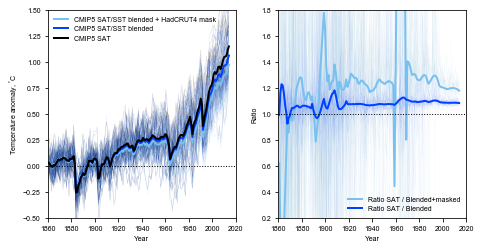

<IPython.core.display.Javascript object>

In [5]:
rc("font", **{"size": 7.0, "sans-serif": ["Arial"]})
params = {"mathtext.default": "regular"}
pl.rcParams.update(params)

model1 = glob.glob(os.path.join(data_path_richardson, "Txax", "*r1i1p1.temp"))
model2 = glob.glob(os.path.join(data_path_richardson, "Had4", "*r1i1p1.temp"))
bl = np.ones((154, len(model1))) * np.nan
bm = np.ones((154, len(model2))) * np.nan
ta = np.ones((154, len(model1))) * np.nan

fig, ax = pl.subplots(1, 2, figsize=(17 / 2.54, 8.8 / 2.54))

colors = ["#000000", "#0040ff", "#78c0ef"]

for i, model in enumerate(model1):
    print(model)
    bl[:, i] = np.loadtxt(model1[i])[:154, 2]
    bm[:, i] = np.loadtxt(model2[i])[:154, 2]
    ta[:, i] = np.loadtxt(model1[i])[:154, 1]
    bl[:, i] = bl[:, i] - np.mean(bl[:40, i])
    bm[:, i] = bm[:, i] - np.mean(bm[:40, i])
    ta[:, i] = ta[:, i] - np.mean(ta[:40, i])
    ax[0].plot(np.arange(1861, 2015), bm[:, i], color=colors[2], lw=0.3, alpha=0.2)
    ax[0].plot(np.arange(1861, 2015), bl[:, i], color=colors[1], lw=0.3, alpha=0.2)
    ax[0].plot(np.arange(1861, 2015), ta[:, i], color=colors[0], lw=0.3, alpha=0.2)
    ax[1].plot(
        np.arange(1861, 2015), ta[:, i] / bm[:, i], color=colors[2], lw=0.3, alpha=0.06
    )
    ax[1].plot(
        np.arange(1861, 2015), ta[:, i] / bl[:, i], color=colors[1], lw=0.3, alpha=0.06
    )

bmmean = np.mean(bm, axis=1)
blmean = np.mean(bl, axis=1)
tamean = np.mean(ta, axis=1)

bmratio = savitzky_golay(tamean / bmmean, 11, 3)
blratio = savitzky_golay(tamean / blmean, 11, 3)

cmip5_data = np.vstack(
    (np.arange(1861, 2015), bmmean, blmean, tamean, bmratio, blratio)
)

ax[0].plot(
    np.arange(1861, 2015),
    bmmean,
    color=colors[2],
    lw=2,
    label="CMIP5 SAT/SST blended + HadCRUT4 mask",
)
ax[0].plot(
    np.arange(1861, 2015), blmean, color=colors[1], lw=2, label="CMIP5 SAT/SST blended"
)
ax[0].plot(np.arange(1861, 2015), tamean, color=colors[0], lw=2, label="CMIP5 SAT")
ax[1].plot(
    np.arange(1861, 2015),
    bmratio,
    color=colors[2],
    lw=2,
    label="Ratio SAT / Blended+masked",
)
ax[1].plot(
    np.arange(1861, 2015), blratio, color=colors[1], lw=2, label="Ratio SAT / Blended"
)
ax[0].axhline(0, lw=1, color="k", ls=":")
ax[1].axhline(1, lw=1, color="k", ls=":")

ax[0].set_xlim(1860, 2020)
ax[0].set_ylim(-0.5, 1.5)
ax[1].set_xlim(1860, 2020)
ax[1].set_ylim(0.2, 1.8)

ax[0].legend(frameon=False)
ax[1].legend(frameon=False)
ax[0].set_xlabel("Year")
ax[0].set_ylabel(r"Temperature anomaly, $^{\circ}$C")
ax[1].set_xlabel("Year")
ax[1].set_ylabel("Ratio")

fig.tight_layout()

pl.show()

-0.0005179461068627753


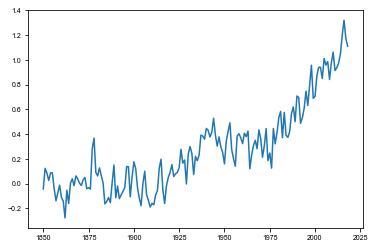

<IPython.core.display.Javascript object>

In [6]:
blratio = cmip5_data[5, :]

cowtan_dat = np.loadtxt(data_path_cowtan_way)

cowtan = cowtan_dat[:, 1] - np.mean(cowtan_dat[:51, 1])

years = cowtan_dat[:, 0]

blratio = np.concatenate((np.ones(11), blratio, np.ones(4) * blratio[-1]))

Tobs = blratio * cowtan

pl.plot(years, Tobs)

print(np.mean(Tobs[:51]))

np.savetxt(output_path, np.column_stack((years, Tobs)))